Making a Mongolian Food Classifier

In [9]:
import fastai
import fastcore
print('Fast.ai version:', fastai.__version__)
print('Fastcore version:', fastcore.__version__)

Fast.ai version: 2.7.14
Fastcore version: 1.5.29


In [10]:
from fastai.vision.all import *

In [11]:
from fastai.vision.widgets import *

In [12]:
from fastdownload import download_url

In [13]:
pip install -U duckduckgo_search

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 62.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.0/8.0 MB 92.1 MB/s eta 0:00:00
  Attempting uninstall: lxml
    Found existing installation: lxml 4.9.4
    Uninstalling lxml-4.9.4:
      Successfully uninstalled lxml-4.9.4


In [14]:
pip install fastcore

In [15]:
from duckduckgo_search import DDGS
from fastcore.all import *

def search_images(term, max_images=30):
    print(f"Searching for '{term}'")
    with DDGS() as ddgs:
        # generator which yields dicts with:
        # {'title','image','thumbnail','url','height','width','source'}
        search_results = ddgs.images(keywords=term)
        # grap number of max_images urls
        image_urls = [next(search_results).get("image") for _ in range(max_images)]
        # convert to L (functionally extended list class from fastai)
        return L(image_urls)

In [16]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [17]:
%cd '/content/drive/MyDrive/Semester 6/Deep Learning/Week 2'

/content/drive/MyDrive/Semester 6/Deep Learning/Week 2


In [18]:
!rm -rf mongolian_food_types

In [19]:
mongolian_food_types = 'бууз','хуушуур','цуйван','нийслэл салат'
path = Path('mongolian_food_types')

In [20]:
mongolian_food_types


('бууз', 'хуушуур', 'цуйван', 'нийслэл салат')

In [21]:
path

Path('mongolian_food_types')

We specified our three bear types, and we created a Python `Path` object. `Path` objects are different from string paths and have some advantages over string paths. For example, `Path` objects work well on both Windows, OSX, and Linux.

In [22]:
if not path.exists():
    path.mkdir()
    for o in mongolian_food_types:
        dest = (path/o)
        dest.mkdir(exist_ok=True)
        urls = search_images(f'{o} ', max_images=50)
        download_images(dest, urls=urls)

Searching for 'бууз '
Searching for 'хуушуур '
Searching for 'цуйван '
Searching for 'нийслэл салат '


This code checks in our path exists. If it doesn't, it creates a bears folder with a subfolder for each of our bear types. Then it downloads images from Bing and saves the images to the correct folder.

In [23]:
path

Path('mongolian_food_types')

In [24]:
fns = get_image_files(path)
fns

(#193) [Path('mongolian_food_types/бууз/819b8866-42be-472a-b503-1cf384cda79d.jpg'),Path('mongolian_food_types/бууз/94b68814-9102-4d0b-af75-6a65c74732e7.jpg'),Path('mongolian_food_types/бууз/7ea1793b-e559-4db1-a68c-a3b78d038536.jpg'),Path('mongolian_food_types/бууз/5ae0ee66-71be-4ae9-a56e-15f947789937.jpg'),Path('mongolian_food_types/бууз/75882f7c-6e4e-4403-931f-cebf65ae2eea.jpg'),Path('mongolian_food_types/бууз/9ba50252-fa4d-4cf9-94ae-8db7ff47a012.jpg'),Path('mongolian_food_types/бууз/68a6d481-26b5-4c88-87b3-74698e60d590.JPG'),Path('mongolian_food_types/бууз/8bf48c67-6943-423f-b3a4-4641736daf95.jpg'),Path('mongolian_food_types/бууз/3c0f1ed5-c43f-4a22-bf3d-0f8aca121ae8.jpeg'),Path('mongolian_food_types/бууз/d0f9aeb0-d975-4d0c-b613-d7f83bb8dbe6.JPG')...]

Sometimes the images that are found don't actually work. They are either corrupted, the site has a certificate error, or some other issue. The `verify_images` method finds the bad images.

In [25]:
failed = verify_images(fns)
failed

(#2) [Path('mongolian_food_types/хуушуур/5f7af683-6ef6-4671-beff-08973724b9f0.jpg'),Path('mongolian_food_types/нийслэл салат/f6d62243-8175-478c-90e4-5931d6082288.jpg')]

Just finding the bad images isn't enough. We also need to remove them. The `unlink` method does this for us.

In [26]:
failed.map(Path.unlink);

In [27]:
help(verify_images)

Help on function verify_images in module fastai.vision.utils:

verify_images(fns)
    Find images in `fns` that can't be opened



## Making our DataLoaders Object

In [28]:
mongolian_food_types = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

We defined the following:

`blocks` - Here we gave a tuple that says what our *indepdendent* and *dependent* variables are. In this case it is images (ImageBlock) and a categorical variables for the labels (CategoryBlock).

`get_items` - We need to tell the data block how to get our items. The `get_image_files` seeks recursively through a path and returns a list of all images in that path.

`splitter` - As you know, splitting our data is very important so we have a good validation set. The `RandomSplitter` is just what it sounds like. You can define the percentage for your validation set (as a decimal). You also define a random seed so we can reproduce the result later.

`get_y` - This tells the data block how to get the independent variable. In this case the `parent_label` method is used. This simply gets the name of the folder the image is in.

`item_tfms` - This defines any transformations your data will go through. The `Resize` tranform is used in this example. For images models all the images must be the same size. The fastai library includes many transform function you can try.

In [29]:
dls = mongolian_food_types.dataloaders(path)

Now that we have our data block created, we can create the DataLoaders object using the data block and our path object.

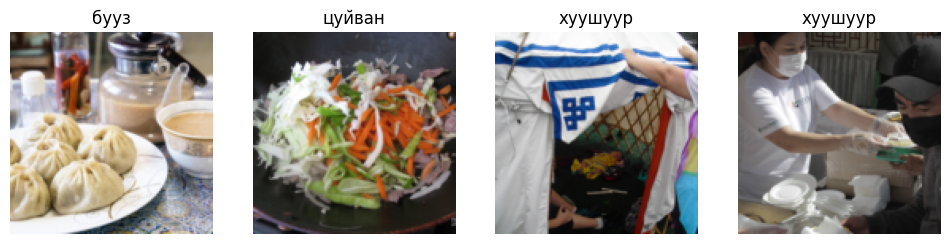

In [30]:
dls.valid.show_batch(max_n=4, nrows=1)

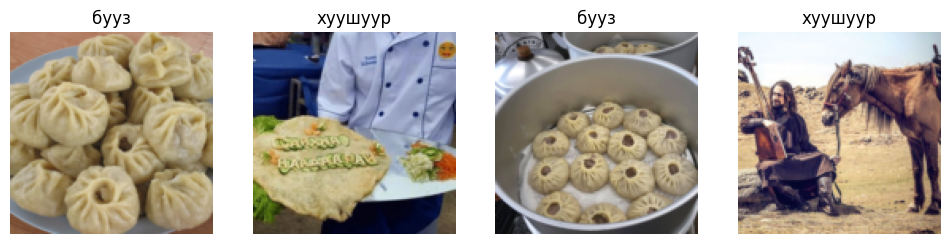

In [31]:
dls.train.show_batch(max_n=4, nrows=1)

Now that you have the DataLoaders object defined we can explore our training and validation dataset using the `show_batch` method.

Our original transform only resized our images. There are other methods we could use to change our images:

- `Resize(128, ResizeMethod.Squish)` - Resizes the images by squishing them.
- `Resize(128, ResizeMethod.Pad, pad_mode='zeros')` - Resizes images by adding black space (padding) around the images.

But doing only one of these may not be what we want. After all you don't really want to do just one transformation for all of your images. We want our model to learn from images that are shown in many different ways!

Luckily fastai provides the `RandomResizedCrop` method. This randomly changes the images so we give our model many differently resized images from the same original image. This is called data augmentation!

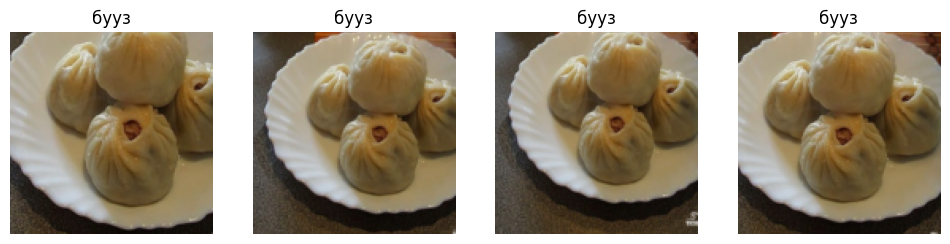

In [32]:
mongolian_food_types = mongolian_food_types.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
dls = mongolian_food_types.dataloaders(path)
dls.train.show_batch(max_n=4, nrows=1, unique=True)

Notice a few things about the above code. First, it uses the `RandomResizedCrop` method to create multiple random transformations. Second, the `unique=True` argument is passed to the `show_batch` method. This shows you the same images that are transformed in different ways by our `RandomResizedCrop` method.

There is another data augmentation tool that fastai provides, the `batch_tfms` method. This method utilizes the GPU to perform tranformations on batches of images to speed the process up. The transformations being done are ones that the fastai team have found to be effective.

Note that `mult=2` is passed and that `RandomResizeCrop` is not done. This is to allow you to see the tranformations easier here.

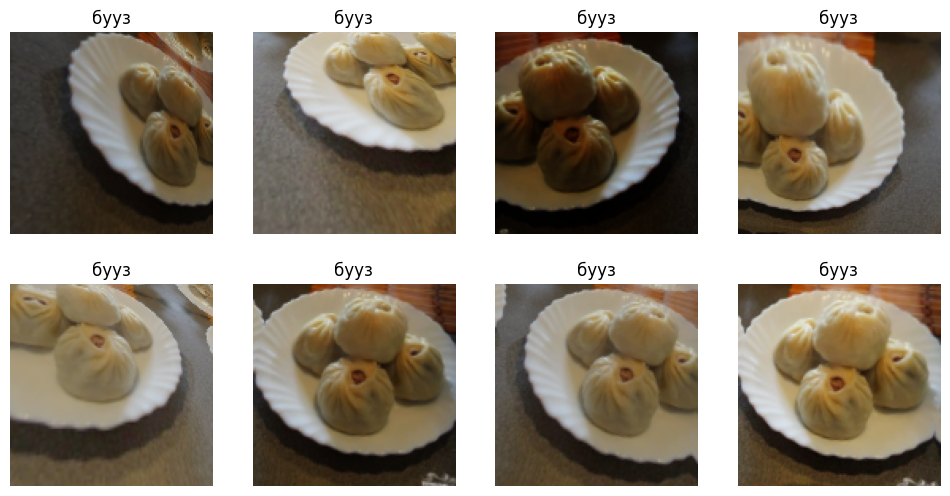

In [33]:
mongolian_food_types = mongolian_food_types.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = mongolian_food_types.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

## Training the Classifier

Now that you have an idea of how to make the DataLoads object, let's go ahead and do the training.

In [34]:
mongolian_food_types = mongolian_food_types.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = mongolian_food_types.dataloaders(path)

Here we define our `cnn_learner` (convolutional neural network learner) using `resenet18` as our base model. We then use `fine_tune` to perform transfer learning on our model.

This `fine_tune` method does some things under the hood so we can use less code, and it works in most cases (but not all!). We will use other methods later.

In [35]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(12)

/usr/local/lib/python3.10/dist-packages/fastai/vision/learner.py:301: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 174MB/s]


epoch,train_loss,valid_loss,error_rate,time
0,2.214410,1.916892,0.631579,00:04


epoch,train_loss,valid_loss,error_rate,time
0,1.496147,1.427203,0.526316,00:03
1,1.502074,1.085269,0.421053,00:03
2,1.350981,0.832284,0.368421,00:03
3,1.208022,0.656025,0.236842,00:04
4,1.062747,0.545969,0.157895,00:03
5,0.952951,0.497492,0.157895,00:03
6,0.872327,0.491029,0.157895,00:03
7,0.779331,0.494474,0.131579,00:04
8,0.705109,0.483147,0.105263,00:03
9,0.647541,0.474483,0.105263,00:03


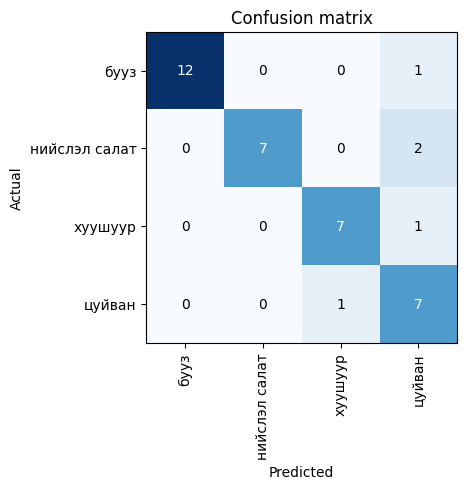

In [36]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

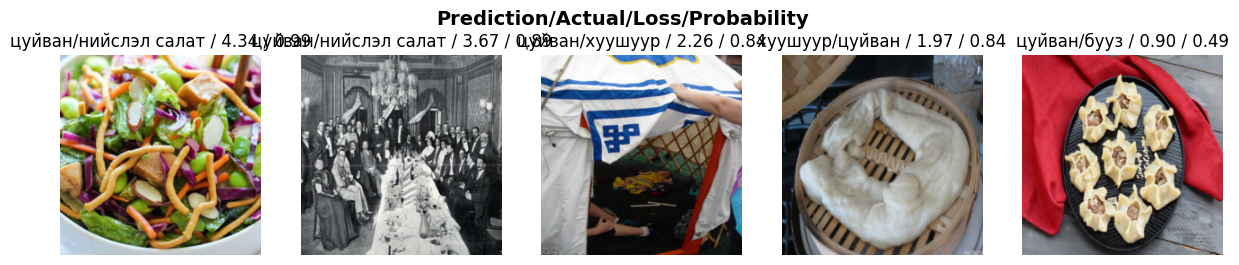

In [37]:
interp.plot_top_losses(5, nrows=1)

In [38]:
learn.export()

In [39]:
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

In [40]:
!ls

01_bear_classifier.ipynb  export.pkl			   mongolian_food_types
bears			  Mongolian_food_classifier.ipynb  pc_parts


In [41]:
from fastai.vision.all import *

In [42]:
learn_inf = load_learner(path/'export.pkl')